# Notebook to replicate the analysis proposed in the Section Data of the paper

In [25]:
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random
sys.path.append("..")
from hnx.communities.hy_mmsbm.model import HyMMSBM
from hnx.generation.hy_mmsbm_sampling import HyMMSBMSampler
from hnx.measures.sub_hypergraph_centrality import subhypergraph_centrality



import hnx
from hnx import Hypergraph
from hnx.readwrite.loaders import load_high_school

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

SIZE_TWO_COLOR = plt.cm.Dark2(0)
SIZE_THREE_COLOR = plt.cm.Dark2(1)
SIZE_FOUR_COLOR = plt.cm.Dark2(2)
SIZE_FIVE_COLOR = plt.cm.Dark2(3)

In [26]:
#sns.set_style("whitegrid", {"grid.color": "0.9"})
params = {'figure.figsize': (7,6),
          'font.family': 'serif', 
          #'text.usetex': True,
          'axes.labelsize': '30',
        'axes.titlesize':'30',
          'xtick.labelsize':'30',
          'ytick.labelsize':'30',
          'legend.fontsize': '30',}
plt.rcParams.update(params)

### Input data

In [74]:
H = load_high_school("../test_data/hs/hs.json")
print(H)

Hypergraph with 327 nodes and 7818 edges.
Distribution of hyperedge sizes: {2: 5498, 3: 2091, 4: 222, 5: 7}


### A) Higher-order degree distributions for different orders

/var/folders/9b/vlz7rpcd3z9_4909fj8gt6rw0000gn/T/ipykernel_47581/2347350905.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(bins, frequency, alpha = .9, label="Size: {}".format(size), s = 95, c = color_dict[size])


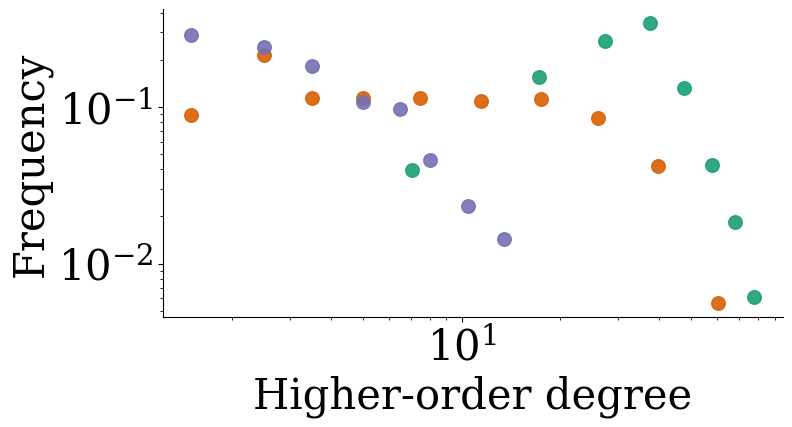

In [28]:
def distr_bin(data, n_bin=30, logbin=True):
    ###This is a very old function copied from my c++ library. It's ugly but works :)
    """ Logarithmic binning of raw positive data;
        Input:
            data = np array,
            bins= number if bins,
            logbin = if true log bin
        Output (array: bins, array: hist) 
        bins: centred bins 
        hist: histogram value / (bin_length*num_el_data) [nonzero]
    """
    if len(data)==0:
        print( "Error empty data\n")
    min_d = float(min(data))
    if logbin and min_d<=0:
        print ("Error nonpositive data\n")
    n_bin = float(n_bin)            #ensure float values
    bins = np.arange(n_bin+1)
    if logbin:
        data = np.array(data)/min_d
        base= np.power(float(max(data)) , 1.0/n_bin)
        bins = np.power(base,bins)
        bins = np.ceil(bins)                   #to avoid problem for small ints
    else:
        data = np.array(data) + min_d          #to include negative data
        delta = (float(max(data)) - float(min(data)))/n_bin
        bins = bins*delta + float(min(data))
    n_bin = int(n_bin)
    #print ('first bin: ', bins[0], 'first data:', min(data), 'max bin:', bins[n_bin], 'max data', float(max(data)))
    hist = np.histogram(data, bins)[0]
    ii = np.nonzero(hist)[0]            #take non zero values of histogram
    bins = bins[ii]
    hist = hist[ii]
    bins=np.append(bins,float(max(data)))          #append the last bin
    bin_len = np.diff(bins)
    bins =  bins[:-1] + bin_len/2.0     #don't return last bin, centred boxes
    if logbin:
        hist = hist/bin_len                 #normalize values
        bins = bins*min_d                   #restore original bin values
    else:
        bins = bins - min_d 
    res = list(zip(bins, hist/float(sum(hist))))    #restore original bin values, norm hist
    return list(zip(*res))

fig, ax = plt.subplots(figsize = (8, 4))
# write three color pastel in a color dict
color_dict = {2: SIZE_TWO_COLOR, 3:SIZE_THREE_COLOR, 4:SIZE_FOUR_COLOR}

for size in [2,3,4]:
    if size == 2:
        logbin = False
    else:
        logbin = True
    degrees = list(H.degree_sequence(size=size).values())
    degrees = [d for d in degrees if d > 0]
    #print(degrees)
    if size == 2:
        n_bin = 8
    else:
        n_bin = 10
    bins, frequency =distr_bin(degrees, n_bin=n_bin, logbin=logbin)
    # print(bins)
    # print(frequency)
    # output of scatter in svg
    plt.scatter(bins, frequency, alpha = .9, label="Size: {}".format(size), s = 95, c = color_dict[size])
#plt.legend(frameon=False, loc = 'lower left', handletextpad =-.2 )
# font size
#plt.rcParams.update({'font.size': 20})
# font serif
#plt.rcParams['font.family'] = 'serif'
# make the dots in the legen closer to the text

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Higher-order degree")
plt.ylabel("Frequency")
sns.despine()
plt.savefig("higher_order_degree_distribution.svg", bbox_inches='tight')

### B) Motifs 

In [29]:
from hnx.motifs.motifs import compute_motifs

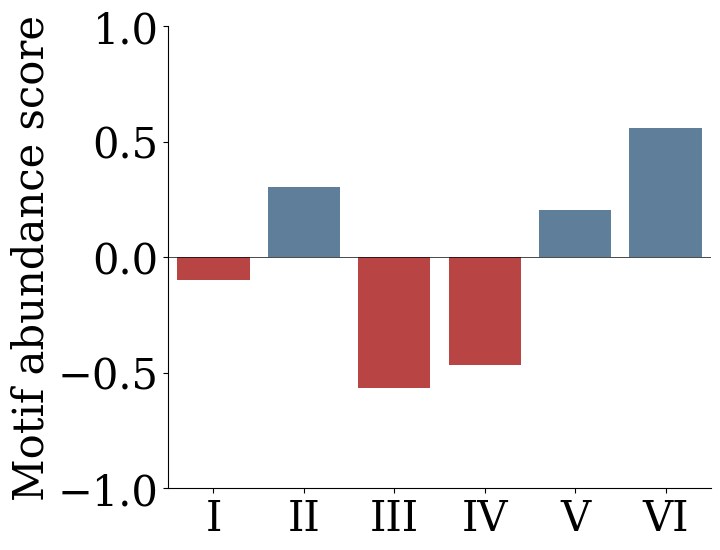

In [30]:
motifs3 = [-0.09743189457908542, 0.3057352878609137, -0.5664795273602301, -0.46704869712770475, 0.20599282046932665, 0.5617529503113179]

# Plot a bar chart of the motif counts
cols = ['#cd3031' if (x < 0) else '#557fa3' for x in motifs3]
g = sns.barplot(x=["I", "II", "III", "IV", "V", "VI"], y=motifs3, palette=cols)
g.axhline(0, color="black", linewidth=0.5)
plt.ylim(-1, 1)
plt.ylabel("Motif abundance score")
sns.despine()
plt.savefig("motifs3.svg", bbox_inches="tight")

### C) Communities 

In [31]:
from hnx.utils import normalize_array, calculate_permutation_matrix
from hnx.communities.hypergraph_mt.model import HypergraphMT
from hnx.viz import draw_communities

In [32]:
# For visualization purposes we analyse only 3 classes
H_filtered = load_high_school("../test_data/hs/hs.json", filter_by_class=['PC', 'PC*', 'PSI*'])

In [33]:
# Fix setting
K = 3  # number of communities
seed = 20  # random seed
n_realizations = 10  # number of realizations with different random initialization
max_iter = 500  # maximum number of EM iteration steps before aborting
check_convergence_every = 1 # number of steps in between every convergence check
normalizeU = False  # if True, then the membership matrix u is normalized such that every row sums to 1
baseline_r0 = False  # if True, then for the first iteration u is initialized around the solution of the Hypergraph Spectral Clustering
verbose = False  # flag to print details

In [34]:
# Model training
model = HypergraphMT(n_realizations=n_realizations, 
                     max_iter=max_iter, 
                     check_convergence_every=check_convergence_every, 
                     verbose=verbose
                    )

u, _, _ = model.fit(H_filtered, 
                    K=K, 
                    seed=seed, 
                    normalizeU=normalizeU, 
                    baseline_r0=baseline_r0
                   )

In [35]:
# Normalize membership matrix by row
u = normalize_array(u, axis=1)

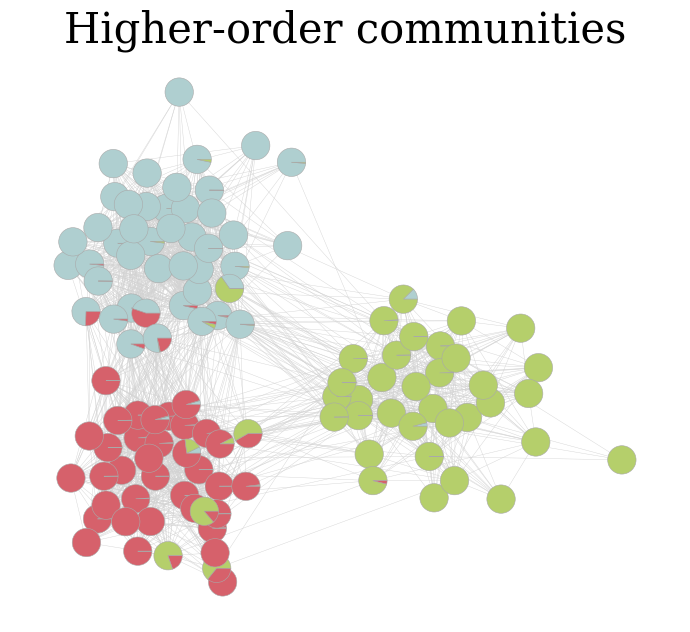

In [36]:
# Visualize with a network and pie charts
col = {0:'#AFCFD0', 1: '#b5cf6b', 2: '#d6616b'}

plt.subplot(1,1,1)
ax=plt.gca()
draw_communities(hypergraph=H_filtered, u=u, col=col, node_size=0.03, ax=ax, with_node_labels=False, 
                 scale=0.8, opt_dist=1, wedge_width=0.4, threshold_group=0., wedge_color='darkgray')
sns.despine()
plt.title("Higher-order communities")
plt.savefig("communities.svg", bbox_inches="tight")

In [37]:
# Visualize with a barplot
df_prop = pd.DataFrame.from_dict(u)
df_prop['id'] = [i for i in range(len(df_prop))]
_, mappingID2Name = H_filtered.binary_incidence_matrix(return_mapping=True)
df_prop['label'] = [mappingID2Name[i] for i in df_prop.id]
df_prop['classID'] = [H_filtered.get_meta(n)['classID'] for n in df_prop['label']]
df_prop.head(3)

,0,1,2,id,label,classID
0,0.000000,1.0,0.000000,0,4,7
1,0.962229,0.0,0.037771,1,9,3
2,0.000000,0.0,1.000000,2,14,2


In [38]:
DF = df_prop[df_prop.classID==3].sort_values(by=[0,1], ascending=False)
#DF = DF.append(df_prop[df_prop.classID==7].sort_values(by=[1,2,0], ascending=False))
DF = DF.append(df_prop[df_prop.classID==2].sort_values(by=[1,0], ascending=False))
DF.head(3)

,0,1,2,id,label,classID
8,1.0,0.0,0.0,8,48,3
10,1.0,0.0,0.0,10,71,3
12,1.0,0.0,0.0,12,80,3


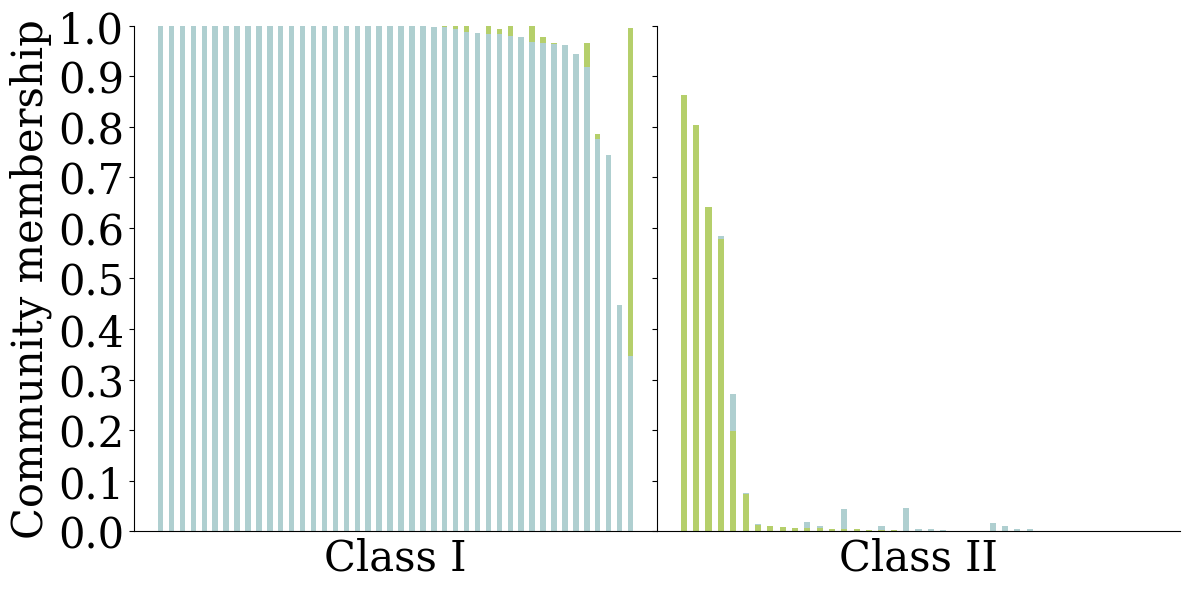

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
#fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

w = 0.5

order = {0: np.array([0, 1]), 1: np.array([1, 0])}
map_ax = {3: 0, 2: 1}
#order = {0: np.array([0, 1, 2]), 1: np.array([1, 2, 0]), 2: np.array([2, 0, 1])}
#map_ax = {3: 0, 7: 1, 2: 2}

for i, n in enumerate(DF.label):
    df_group_id = DF[DF.label==n]
    axi = map_ax[df_group_id.classID.values[0]]
    for j, x in enumerate(order[axi]):
        value = df_group_id.iloc[:, x].values[0]
        bot = 0
        for xp in order[axi][:j]:
            bot += df_group_id.iloc[:, xp].values[0]
        if j == 0:
            ax[axi].bar(i, value, width=w, align='center',
               ecolor='black', capsize=3, color=col[x])
        else: 
            ax[axi].bar(i, value, width=w, align='center',
               ecolor='black', capsize=3, color=col[x], bottom=bot)
    
ax[0].set_ylim(0.0, 1.0)
ax[0].set_yticks(np.arange(0., 1.1, 0.1))
ax[0].set_yticklabels(np.round(np.arange(0., 1.1, 0.1),1))
ax[0].set_ylabel(r'Community membership')

ax[0].set_xticks([])
ax[0].set_xlabel('Class I')

ax[1].set_xticks([])
ax[1].set_xlabel('Class II')

#ax[2].set_xticks([])
#ax[2].set_xlabel('Class III')

ax[0].grid(axis='x')
ax[1].grid(axis='x')
#ax[2].grid(axis='x')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
sns.despine()
plt.savefig("communities_barplot.svg", bbox_inches="tight")
plt.show();

### D) Statistics of the filtered systems after applying SVH
(one statistic of Fede’s choice, for instance fraction of preserved higher-order interactions for each order after
applying the SVH filter. It is better if the dataset has at least 4 different orders, but again it is a trade-off)

In [78]:
from hnx.filters import get_svh

import pandas as pd 

params = {'figure.figsize': (7,6),
          'font.family': 'serif', 
          #'text.usetex': True,
          'axes.labelsize': '25',
        'axes.titlesize':'30',
          'xtick.labelsize':'30',
          'ytick.labelsize':'30',
          'legend.fontsize': '20',}
plt.rcParams.update(params)
validated = get_svh(H, approximate_pvalue=True, mp=True)

In [79]:
df = pd.DataFrame()

for size in validated:
    if size < 5:
        data = validated[size]
        print(len(data))
        for d in range(data.shape[0]):
            df = df.append({'size': size, 'fdr': 'Total interactions'}, ignore_index=True)
        data = data[data['fdr']]
        print(len(data))
        for d in range(data.shape[0]):
            df = df.append({'size': size, 'fdr': 'Filtered interactions'}, ignore_index=True)

5498
1217
2091
518
222
62


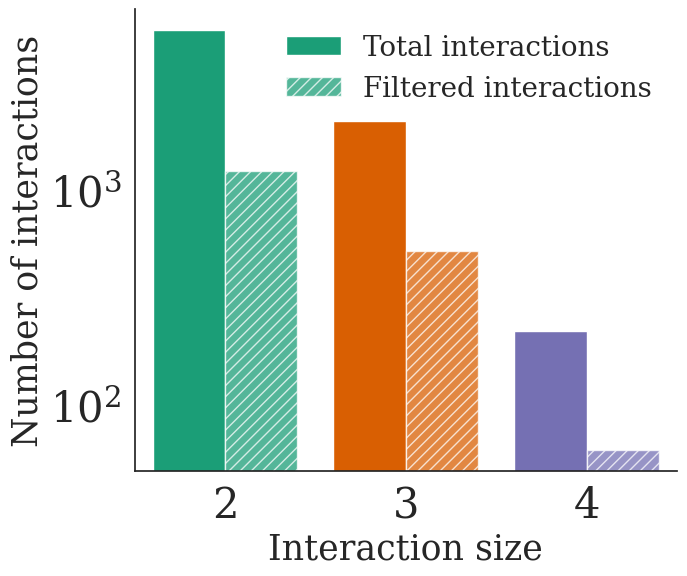

In [80]:

g = sns.countplot(data=df, x="size", hue="fdr")

count = 0
g.patches[0].set_facecolor(SIZE_TWO_COLOR)
g.patches[1].set_facecolor(SIZE_THREE_COLOR)
g.patches[2].set_facecolor(SIZE_FOUR_COLOR)
g.patches[3].set_facecolor(SIZE_TWO_COLOR)
g.patches[3].set_alpha(0.75)
g.patches[3].set_hatch('///')
g.patches[4].set_facecolor(SIZE_THREE_COLOR)
g.patches[4].set_alpha(0.75)
g.patches[4].set_hatch('///')
g.patches[5].set_facecolor(SIZE_FOUR_COLOR)
g.patches[5].set_alpha(0.75)
g.patches[5].set_hatch('///')

plt.ylabel("Number of interactions")
plt.yscale("log")
plt.xlabel("Interaction size")
sns.despine()
plt.legend(frameon=False)
plt.savefig("svh.svg", bbox_inches="tight")

### E) Ability of the sampling method to reproduce one measure 
(one centrality measure distribution not covered so far)

In [111]:

params = {'figure.figsize': (7,6),
          'font.family': 'serif', 
          #'text.usetex': True,
          'axes.labelsize': '25',
        'axes.titlesize':'30',
          'xtick.labelsize':'25',
          'ytick.labelsize':'25',
          'legend.fontsize': '20',}
plt.rcParams.update(params)

SEED = 112233
np.random.seed(SEED)
random.seed(SEED)

# First, infer generative parameters utilizing Hy-MMSBM.
model = HyMMSBM(K=9, assortative=True)
model.fit(H, n_iter=100)

# Sample based on these
sampler = HyMMSBMSampler(
    u = model.u,
    w = model.w,
    max_hye_size = None,
    exact_dyadic_sampling = True,
    burn_in_steps = 1000,
    intermediate_steps = 1000,
)
samples = sampler.sample(
    deg_seq = None,
    dim_seq = None,
    avg_deg = None,
    initial_hyg = H,
    allow_rescaling = False
)
sampled_h = [next(samples) for _ in range(10)]

/Users/francesco/PycharmProjects/hnx/tutorials/../hnx/generation/hy_mmsbm_sampling.py:489: RuntimeWarning: overflow encountered in expm1
  np.expm1(prob_new) / np.expm1(prob_old),
/Users/francesco/PycharmProjects/hnx/tutorials/../hnx/generation/hy_mmsbm_sampling.py:489: RuntimeWarning: overflow encountered in expm1
  np.expm1(prob_new) / np.expm1(prob_old),
/Users/francesco/PycharmProjects/hnx/tutorials/../hnx/generation/hy_mmsbm_sampling.py:489: RuntimeWarning: overflow encountered in expm1
  np.expm1(prob_new) / np.expm1(prob_old),
/Users/francesco/PycharmProjects/hnx/tutorials/../hnx/generation/hy_mmsbm_sampling.py:489: RuntimeWarning: overflow encountered in expm1
  np.expm1(prob_new) / np.expm1(prob_old),
/Users/francesco/PycharmProjects/hnx/tutorials/../hnx/generation/hy_mmsbm_sampling.py:489: RuntimeWarning: overflow encountered in expm1
  np.expm1(prob_new) / np.expm1(prob_old),
/Users/francesco/PycharmProjects/hnx/tutorials/../hnx/generation/hy_mmsbm_sampling.py:489: RuntimeWa

In [112]:
samples_centr = [subhypergraph_centrality(h) for h in sampled_h]
original_centr = subhypergraph_centrality(H)

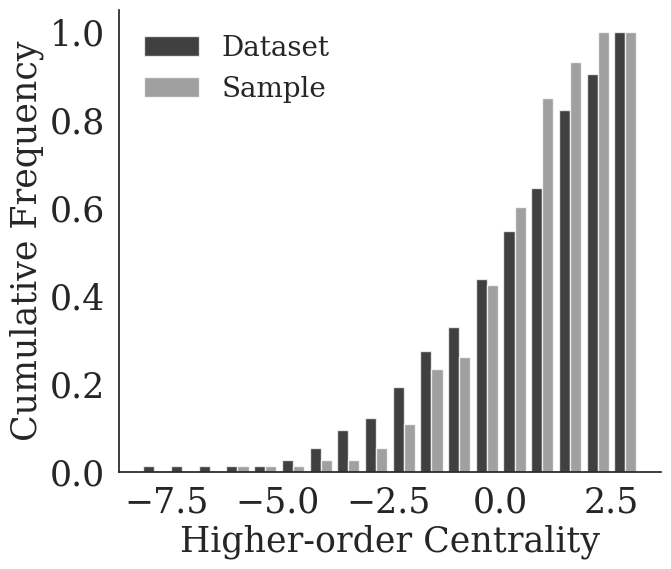

In [113]:
SAMPLE_IDX = 0
sample_centr = samples_centr[SAMPLE_IDX]

# Version 3
#colormap=plt.rcParams['axes.prop_cycle'].by_key()['color']

hist = plt.hist(
    [
        original_centr - np.mean(original_centr), 
        samples_centr[SAMPLE_IDX] - np.mean(samples_centr[SAMPLE_IDX])
    ],
    # label=["Dataset", "Sample"],
    cumulative=True,
    color=['black','grey'], 
    alpha=0.75,
    #rwidth=0.5, 
    bins=18, 
    density=True,
)
xmin, xmax = plt.xlim()

plt.xlim(xmin, xmax)
plt.ylabel("Cumulative Frequency")
plt.xlabel("Higher-order Centrality")

sns.despine()

plt.legend(frameon=False, labels=["Dataset", "Sample"], loc="upper left")
plt.savefig(f"./sampling_and_centrality.svg")

### F) Temporal higher-order properties
one plot from the work of Luca (let us produce an alternative figure with respect to the arXiv. It should be a figure less cool, we keep the cool figure for the original work (one centrality measure distribution not covered so far)

In [97]:
correlation_by_order = np.load("./_example_data/temporal_correlations.npy")

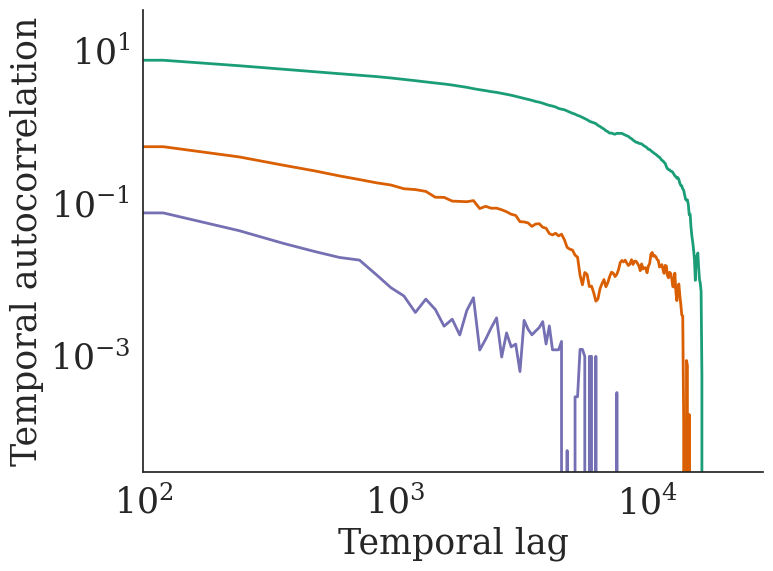

In [120]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

for d in range(3):
    ax.plot(range(0,1440*20,6*20),correlation_by_order[d,:], label="size = %s" % (d+2),
                color=plt.cm.Dark2(d), lw=2)

ax.set_xlabel("Temporal lag")
ax.set_ylabel("Temporal autocorrelation")
ax.tick_params(axis='both', which='major')

ax.loglog()
ax.set_xlim(left=100,right=1441*20)
sns.despine()

plt.savefig("temporal_correlation.svg", bbox_inches="tight")

### G) Statistics of a higher-order spreading process run on top of it 
(e.g. number of infected individuals as a function of time for some parameters lambda pairwise and triangles (please write the value of the parameters in the main text or in the caption). I suggest we choose a social system, because otherwise this does not make sense

In [116]:
social_contagion_data = np.load("./_example_data/social_contagion.npy")

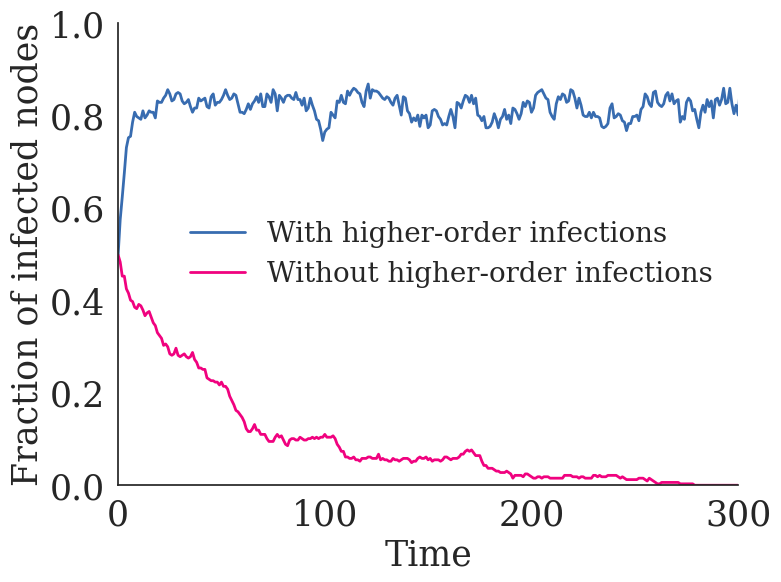

In [119]:
# We plot the results
fig, ax = plt.subplots(figsize=(8, 6))

T = 500
ax.plot(range(T),social_contagion_data[:,0], 
        lw=2, c=plt.cm.Accent(4),
        label="With higher-order infections")
ax.plot(range(T),social_contagion_data[:,1], 
        lw=2, c=plt.cm.Accent(5),
        label="Without higher-order infections")

ax.set_xlim(0,300)
ax.set_ylim(0,1)
ax.tick_params(axis='both', which='major')

ax.set_xlabel("Time")
ax.set_ylabel("Fraction of infected nodes")
ax.legend(frameon=False, loc="right")
sns.despine()
plt.savefig("social_contagion.svg", bbox_inches="tight")

### H) 2 or 3 of different visualizations 
chosen by Francesco and Martina.

In [101]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from hnx.readwrite.loaders import load_high_school
H = load_high_school("../test_data/hs/hs.json", filter_by_class=['2BIO2', '2BIO3'])
print(H)

Hypergraph with 73 nodes and 1666 edges.
Distribution of hyperedge sizes: {2: 1059, 3: 547, 4: 58, 5: 2}


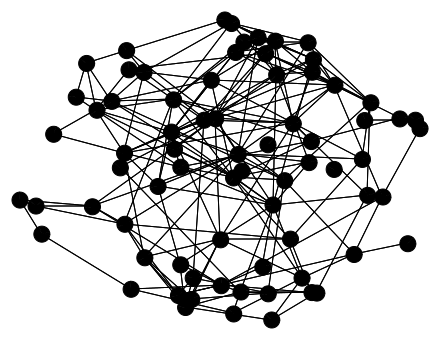

In [102]:
from hnx.viz.draw_pie import draw_pie
from IPython.display import SVG

SVG(draw_pie(H, num_edges=200))

In [103]:
from hnx.filters import get_svh

hs_svh = get_svh(H, approximate_pvalue=True, mp=True)

In [104]:
e4 = hs_svh[4]
e4 = e4[e4['fdr']]
lim = e4['pvalue']
lim = list(lim)
lim = list(sorted(lim))
print(lim)
lim = lim[3]

[6.646224893523687e-86, 5.221769486832966e-37, 5.1957731308802715e-31, 3.5242113407236746e-22, 4.697860857679602e-22, 4.047103660572123e-21, 6.565064407839767e-19, 4.2710868999582136e-18, 2.518236429926194e-17, 2.518236429926194e-17, 4.2951202654040064e-16, 3.266356722349142e-15, 1.041024361796429e-14, 2.0422272368275188e-13, 3.4154248400050345e-10, 6.604145508244868e-10, 1.0220037084538145e-09, 1.985745040998325e-08, 6.168536006054856e-08]


In [105]:
edges = []
lim = float(lim)

for size in hs_svh:
    for i in range(len(hs_svh[size])):
        a = float(hs_svh[size]['pvalue'][i])
        b = bool(hs_svh[size]['fdr'][i])
        if a <= lim and b:
            edges.append(hs_svh[size]['edge'][i])

print(len(edges))

H2 = Hypergraph(edges)
lcc = H2.largest_component()
H2 = H2.subhypergraph(lcc)


119


/Users/francesco/PycharmProjects/hnx/venv/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


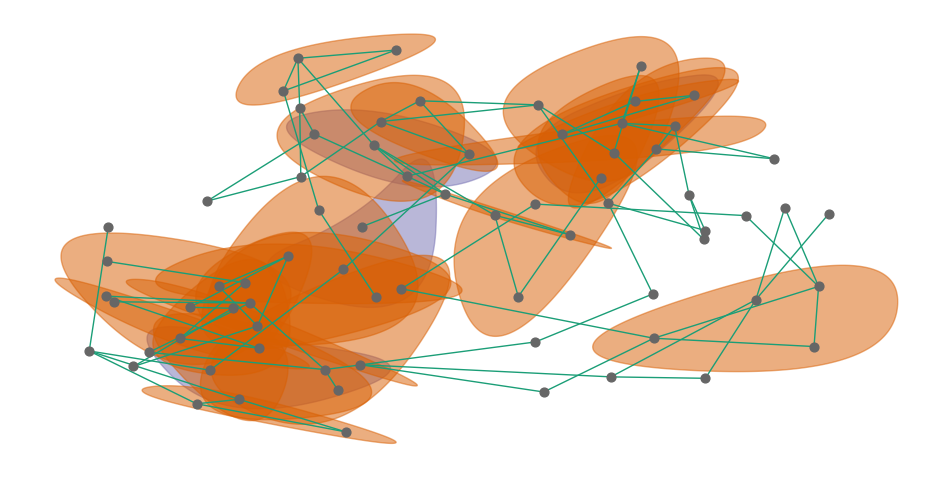

In [106]:
from hnx.viz import draw_HG


figsize = (12,6)
plt.figure(figsize = figsize)
draw_HG(H2, link_color=plt.cm.Dark2(0), node_color=plt.cm.Accent(7), hyperlink_color_by_order = {2:plt.cm.Dark2(1), 3:plt.cm.Dark2(2)}, save_name = 'hypergraph_viz')